## Init

In [3]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder,StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import numpy as np 
import sqlite3

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', 1000)

Regarder la perf du modele sur la precision le f1 score et le recall
L'utilisation du mlflow 
Se renseigner sur Support Vector Classifier et Decision Tree 


In [16]:
## Jouer avec mlflow en testant différent modèles (pas la meme manière de récuperer les features importances)
## Jouer avec les hyperparamètres
## COmprendre mieux les métriques 
## Prouver nos choix de colonnes? 

In [17]:
# COMMENT ON A FAIT POUR GERER LE UNBALANCED

## Suite à l'analyse de corrélation, suppression des colonnes qui ont un taux de corrélation supérieure à 0.95

In [4]:
# Chemin vers votre fichier de base de données SQLite
sqlite_db_path = "/home/yanis/Téléchargements/Projet chef d'oeuvre/bdd/base_de_donnees.db"

# Créer une connexion à la base de données SQLite
conn = sqlite3.connect(sqlite_db_path)

# Nom de la table que vous souhaitez charger dans un DataFrame
table_name = "customer_data"

# Utiliser read_sql_query pour charger les données dans un DataFrame
query = f"SELECT * FROM {table_name}"
df_filtered = pd.read_sql_query(query, conn)

# Fermer la connexion
conn.close()    

In [5]:
variables_to_remove = ['euribor3m', 'nr.employed','emp.var.rate','contact', 'month','day_of_week','poutcome'] 

In [6]:
df_filtered = df_filtered.drop(variables_to_remove, axis=1)

In [7]:
df_filtered.head(2)

,age,job,marital,education,defaut,housing,loan,duration,campaign,pdays,previous,cons_price_idx,cons_conf_idx,y,age_group
0,56,housemaid,married,basic.education,no,no,no,261,1,999,0,93.994,-36.4,no,Group 3
1,57,services,married,high.school,unknown,no,no,149,1,999,0,93.994,-36.4,no,Group 3


In [8]:
num_columns = ['duration', 'campaign', 'pdays', 'previous', 'cons_price_idx', 'cons_conf_idx'] 
cat_columns = ['job', 'marital', 'education', 'defaut', 'housing','loan', 'age_group'] 

In [9]:
#df_filtered.iloc[0].to_json()

In [12]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_columns),
        ('cat', OneHotEncoder(), cat_columns)
    ],
    remainder="passthrough" 
)

In [13]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()
df_filtered["y"] = label_encoder.fit_transform(df_filtered["y"])

In [14]:
# Réinitialiser les index
X = df_filtered.drop(columns=['y']).reset_index(drop=True)  # Features
y = df_filtered['y'].reset_index(drop=True)  # Target variable

# Division des données en ensembles d'entraînement et de test (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Affichage des dimensions des ensembles d'entraînement et de test
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)


Training set shape: (32886, 14) (32886,)
Testing set shape: (8222, 14) (8222,)


In [15]:
# Vérification de l'absence de valeurs NaN dans les nouveaux ensembles
print("NaN dans y_train_clean:", y_train.isnull().sum())
print("NaN dans y_test_clean:", y_test.isnull().sum())

NaN dans y_train_clean: 0
NaN dans y_test_clean: 0


## Regression logistique

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression # Library
pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('model',LogisticRegression(C=10,random_state=42))
    ]
)

In [17]:
pipeline.fit(X_train,y_train)

/home/yanis/miniconda3/envs/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['duration', 'campaign',
                                                   'pdays', 'previous',
                                                   'cons_price_idx',
                                                   'cons_conf_idx']),
                                                 ('cat', OneHotEncoder(),
                                                  ['job', 'marital',
                                                   'education', 'defaut',
                                                   'housing', 'loan',
                                                   'age_group'])])),
                ('model', LogisticRegression(C=10, random_state=42))])

In [18]:
y_pred = pipeline.predict(X_test)

In [19]:
print(classification_report(y_test, y_pred ))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95      7324
           1       0.63      0.34      0.44       898

    accuracy                           0.91      8222
   macro avg       0.78      0.66      0.70      8222
weighted avg       0.89      0.91      0.89      8222



In [20]:
print(recall_score(y_test, y_pred ))

0.33964365256124723


In [21]:
from sklearn.metrics import f1_score
# Calculer le F1 score moyen pour toutes les classes
f1 = f1_score(y_test, y_pred, average='macro')  # 'macro' ne prend pas en compte le déséquilibre des classes
print('F1 Score (Macro):', f1)


F1 Score (Macro): 0.6954568719357793


In [22]:
from sklearn.metrics import f1_score

# y_test est votre ensemble de données de test réel
# y_pred sont vos prédictions faites par le modèle de régression logistique
score_f1 = f1_score(y_test, y_pred, average='binary')  # Utilisez 'binary' si vous avez une classification binaire

print("F1 Score:", score_f1)


F1 Score: 0.4420289855072464


Le F1 score est défini comme 2 fois le produit de la précision et du rappel divisé par la somme de la précision et du rappel :
F1 = 2 * (Precision*Recall)/ (Precision + recall)


## Regression logisitic 

### experiment: experience = bank additionnal dans notre cas 
### Run: Au sein d'un experiment c'est ce qu'on va comparer pour tirer le test plus intéressant pour nous

## Feature importance

In [55]:
model_estimator = pipeline.named_steps["model"]

column_names= pipeline[0].get_feature_names_out()
feature_importance = pd.Series(model_estimator.coef_[0], index=column_names)
plot_importances_df =\
        feature_importance\
        .nlargest(10)\
        .sort_values()\
        .to_frame('value')\
        .rename_axis('feature')\
        .reset_index()

import plotly.express as px
fig = px.bar(plot_importances_df, 
                x='value', 
                y='feature')
fig.update_layout(title_text="feature importance", title_x=0.5) 
fig.update(layout_showlegend=False)

fig.show()

In [56]:
#all_col = new_col + X_train.columns
column_names= pipeline[0].get_feature_names_out()
coefficients = pipeline.named_steps['model'].coef_[0]  # Accéder aux coefficients du modèle

# Créer un DataFrame pour une meilleure visualisation
feature_importance = pd.DataFrame(coefficients, 
                                  index=column_names, 
                                  columns=['Coefficient']).sort_values(by='Coefficient', ascending=False)

print(feature_importance)


                                    Coefficient
num__duration                          1.104166
cat__job_student                       0.597426
cat__age_group_Group 4                 0.581189
cat__job_retired                       0.373838
cat__age_group_Group 5                 0.249735
cat__job_unemployed                    0.148007
num__previous                          0.123926
num__cons_conf_idx                     0.031102
cat__education_unknown                 0.029391
cat__education_illiterate              0.019407
remainder__age                         0.005310
cat__defaut_yes                       -0.002186
cat__job_admin.                       -0.025584
cat__job_unknown                      -0.040574
cat__job_housemaid                    -0.051317
cat__education_university.degree      -0.067105
cat__defaut_no                        -0.119045
cat__education_professional.course    -0.143033
cat__marital_single                   -0.167914
num__campaign                         -0

In [27]:
pipeline.fit(X_train, y_train)


2024/05/09 00:20:16 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'de48113d0af0483f87bc46e98d13a173', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
/home/yanis/miniconda3/envs/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
2024/05/09 00:20:27 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/yanis/miniconda3/envs/venv/lib/python3.10/site-packages/mlflow/types/utils.py:394: UserWarning: H

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['duration', 'campaign',
                                                   'pdays', 'previous',
                                                   'cons_price_idx',
                                                   'cons_conf_idx']),
                                                 ('cat', OneHotEncoder(),
                                                  ['job', 'marital',
                                                   'education', 'defaut',
                                                   'housing', 'loan',
                                                   'age_group'])])),
                ('model', LogisticRegression(C=10, random_state=42))])

/home/yanis/miniconda3/envs/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

2024/05/08 23:41:17 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/yanis/miniconda3/envs/venv/lib/python3.10/site-packages/mlflow/types/utils.py:394: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the mod

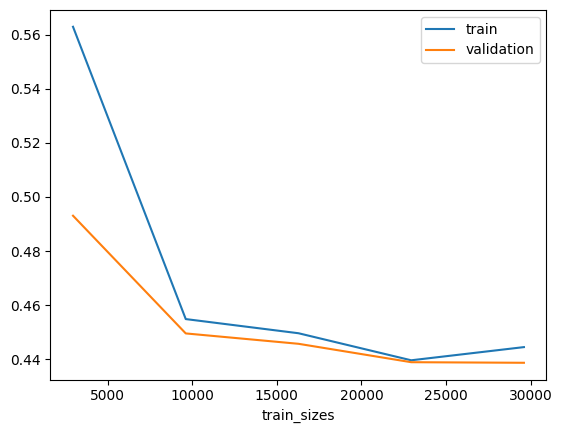

In [66]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import mlflow
from mlflow import sklearn as mlf_sklearn

# Activer l'enregistrement automatique
mlflow.sklearn.autolog(log_input_examples=False, log_model_signatures=True, log_models=True, log_datasets=False, disable=False, 
                       exclusive=False, disable_for_unsupported_versions=False, silent=False, max_tuning_runs=5, 
                       log_post_training_metrics=False, serialization_format='cloudpickle', registered_model_name=None, 
                       pos_label=None, extra_tags=None)

# Débuter une expérience MLflow
with mlflow.start_run(run_name="first_logistic_regression"):
    # Entraîner le modèle (cela déclenche autolog pour enregistrer le modèle et les métriques automatiquement)
    pipeline.fit(X_train, y_train)

    # Prédictions sur l'ensemble de test
    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]  # probabilités pour la classe positive

    # Calcul des métriques
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    mlflow.log_metric("test_accuracy", accuracy )
    mlflow.log_metric("precision", precision )
    mlflow.log_metric("recall", recall )
    mlflow.log_metric("f1", f1 )
    mlflow.log_metric("roc_auc", roc_auc )

   # N, train_score, val_score = learning_curve(pipeline, X_train, y_train,cv=3, scoring="f1", random_state=42)
    
    plt.plot(N, train_score.mean(axis=1), label='train')
    plt.plot(N, pd.DataFrame(val_score).mean(axis=1), label='validation')
    plt.xlabel('train_sizes')
    plt.legend()
    plt.savefig("learning_curve.png")
    
    coefficients = pipeline.named_steps['model'].coef_[0]  # Accéder aux coefficients du modèle

    # Créer un DataFrame pour une meilleure visualisation
    feature_importance = pd.DataFrame(coefficients, 
                                    index=pipeline[0].get_feature_names_out(), 
                                    columns=['Coefficient']).sort_values(by='Coefficient', ascending=False)
    
    feature_importance.to_html("feature_importance.html")


    # Vous pouvez toujours ajouter d'autres artefacts si nécessaire
    mlflow.log_artifact("learning_curve.png")
    mlflow.log_artifact("feature_importance.html")


In [ ]:
-----------

SyntaxError: invalid syntax (353815310.py, line 1)

### Random forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

pipeline_rfc = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(n_estimators=100, random_state=42))
])


In [ ]:
pipeline_rfc.fit(X_train,y_train)

2024/05/04 09:52:25 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '4293900c76a94e858a003a66e6da2231', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2024/05/04 09:52:32 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/yanis/miniconda3/envs/venv/lib/python3.10/site-packages/mlflow/types/utils.py:394: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With M

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['duration', 'campaign',
                                                   'pdays', 'previous',
                                                   'cons.price.idx',
                                                   'cons.conf.idx']),
                                                 ('cat', OneHotEncoder(),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan',
                                                   'age_group']),
                                                 ('drop_feature', 'drop',
                                                  ['euribor3m', 'nr.employed',
                                                   'emp.var.rate', 'contact',
                                                   'month', 'day_of_week',
                                                   'poutcome'])])),
                ('model', RandomForestClassifier(random_state=42))])

2024/05/04 09:58:09 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/yanis/miniconda3/envs/venv/lib/python3.10/site-packages/mlflow/types/utils.py:394: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2024/05/04 09:58:11 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/yanis/miniconda3/envs/venv/lib

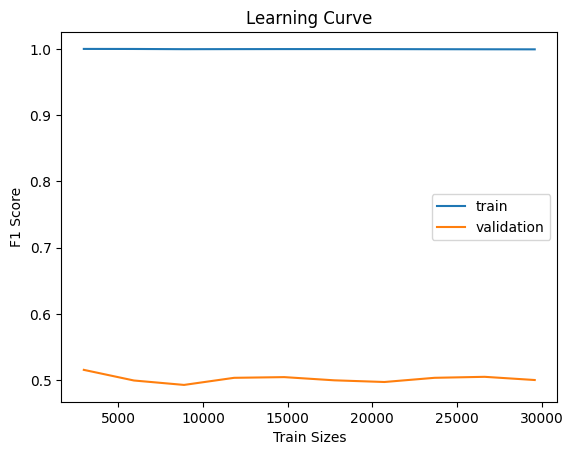

In [ ]:

# Configuration du pipeline avec Random Forest
pipeline_rfc = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Activer l'enregistrement automatique
mlflow.sklearn.autolog(log_input_examples=False, log_model_signatures=True, log_models=True, 
                       log_datasets=False, disable=False, exclusive=False, disable_for_unsupported_versions=False, 
                       silent=False, max_tuning_runs=5, log_post_training_metrics=False, 
                       serialization_format='cloudpickle', registered_model_name=None, 
                       pos_label=None, extra_tags=None)

# Débuter une expérience MLflow
with mlflow.start_run(run_name="random_forest_classification"):
    # Entraîner le modèle
    pipeline_rfc.fit(X_train, y_train)

    # Prédictions sur l'ensemble de test
    y_pred = pipeline_rfc.predict(X_test)
    y_pred_proba = pipeline_rfc.predict_proba(X_test)[:, 1]  # probabilités pour la classe positive

    # Calcul des métriques
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    mlflow.log_metric("test_accuracy", accuracy)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1", f1)
    mlflow.log_metric("roc_auc", roc_auc)

    # Learning Curve
    N, train_score, val_score = learning_curve(pipeline_rfc, X_train, y_train, cv=10, scoring="f1", train_sizes=np.linspace(0.1, 1.0, 10))
    plt.figure()
    plt.plot(N, train_score.mean(axis=1), label='train')
    plt.plot(N, pd.DataFrame(val_score).mean(axis=1), label='validation')
    plt.xlabel('Train Sizes')
    plt.ylabel('F1 Score')
    plt.title('Learning Curve')
    plt.legend()
    plt.savefig("learning_curve.png")

    # Feature Importance
    feature_importances = pipeline_rfc.named_steps['model'].feature_importances_
    new_col = pipeline_rfc['preprocessor'].transformers_[1][1].get_feature_names_out(cat_columns)
    all_col = list(num_columns) + list(new_col)
    feature_importance = pd.DataFrame(feature_importances, index=all_col, columns=['Importance']).sort_values(by='Importance', ascending=False)
    feature_importance.to_html("feature_importance.html")

    # Logging artifacts
    mlflow.log_artifact("learning_curve.png")
    mlflow.log_artifact("feature_importance.html")

# L'exécution est automatiquement clôturée avec le bloc 'with'


## SVM

In [23]:
from sklearn.svm import LinearSVC

In [28]:
pipeline_svm.fit(X_train, y_train)

2024/05/09 00:22:24 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'd7b887702e89497a91e418d8af2fe82c', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
/home/yanis/miniconda3/envs/venv/lib/python3.10/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/yanis/miniconda3/envs/venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
2024/05/09 00:23:45 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/yanis/miniconda3/envs/venv/lib/python3.10/site-packages/mlflow/types/utils.py:394: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot repres

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['duration', 'campaign',
                                                   'pdays', 'previous',
                                                   'cons_price_idx',
                                                   'cons_conf_idx']),
                                                 ('cat', OneHotEncoder(),
                                                  ['job', 'marital',
                                                   'education', 'defaut',
                                                   'housing', 'loan',
                                                   'age_group'])])),
                ('scaler', StandardScaler()),
                ('model', LinearSVC(random_state=42))])

In [26]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVC
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import learning_curve
import mlflow
from mlflow import sklearn as mlf_sklearn

# Configuration du pipeline avec SVM
pipeline_svm = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler()),  # SVM bénéficie souvent de la mise à l'échelle des caractéristiques
    ('model', LinearSVC(random_state=42))
])

# Activer l'enregistrement automatique
mlflow.sklearn.autolog(log_input_examples=False, log_model_signatures=True, log_models=True, 
                       log_datasets=False, disable=False, exclusive=False, disable_for_unsupported_versions=False, 
                       silent=False, max_tuning_runs=5, log_post_training_metrics=False, 
                       serialization_format='cloudpickle', registered_model_name=None, 
                       pos_label=None, extra_tags=None)

# Débuter une expérience MLflow
with mlflow.start_run(run_name="svm_classification"):
    # Entraîner le modèle
    pipeline_svm.fit(X_train, y_train)

    # Prédictions sur l'ensemble de test
    y_pred = pipeline_svm.predict(X_test)
    #y_pred_proba = pipeline_svm.predict_proba(X_test)[:, 1]  # probabilités pour la classe positive

    # Calcul des métriques
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    #roc_auc = roc_auc_score(y_test, y_pred_proba)
    mlflow.log_metric("test_accuracy", accuracy)
    mlflow.log_metric("precision", precision) 
    mlflow.log_metric("recall", recall) 
    mlflow.log_metric("f1", f1) 
    #mlflow.log_metric("roc_auc", roc_auc)

    # Learning Curve
    N, train_score, val_score = learning_curve(pipeline_svm, X_train, y_train, cv=3, scoring="f1", train_sizes=np.linspace(0.1, 1.0, 10))
    plt.figure()
    plt.plot(N, train_score.mean(axis=1), label='train')
    plt.plot(N, pd.DataFrame(val_score).mean(axis=1), label='validation')
    plt.xlabel('Train Sizes')
    plt.ylabel('F1 Score')
    plt.title('Learning Curve')
    plt.legend()
    plt.savefig("learning_curve.png")
    mlflow.log_artifact("learning_curve.png")

# L'exécution est automatiquement clôturée avec le bloc 'with'


/home/yanis/miniconda3/envs/venv/lib/python3.10/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/yanis/miniconda3/envs/venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
2024/05/09 00:07:11 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/yanis/miniconda3/envs/venv/lib/python3.10/site-packages/mlflow/types/utils.py:394: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training 

In [ ]:
"""import pickle

# Enregistrez le modèle dans un fichier .pickle après l'avoir entraîné
with open("/home/yanis/Téléchargements/Projet chef d'oeuvre/api_ai/modele/logistic_regression.pickle", 'wb') as file:
    pickle.dump(model, file)
"""

'import pickle\n\n# Enregistrez le modèle dans un fichier .pickle après l\'avoir entraîné\nwith open("/home/yanis/Téléchargements/Projet chef d\'oeuvre/api_ai/modele/logistic_regression.pickle", \'wb\') as file:\n    pickle.dump(model, file)\n'

In [ ]:
"""data_example = {
    'duration': [200], 
    'campaign': [2], 
    'pdays': [999], 
    'previous': [0], 
    'cons.price.idx': [93.994], 
    'cons.conf.idx': [-36.4], 
    # Encodage One-Hot pour 'job'
    'job_admin.': [1], 
    'job_blue-collar': [0], 
    'job_entrepreneur': [0], 
    'job_housemaid': [0], 
    'job_management': [0], 
    'job_retired': [0], 
    'job_self-employed': [0], 
    'job_services': [0], 
    'job_student': [0], 
    'job_technician': [0], 
    'job_unemployed': [0], 
    'job_unknown': [0], 
    # Encodage One-Hot pour 'marital'
    'marital_divorced': [0], 
    'marital_married': [1], 
    'marital_single': [0], 
    # Encodage One-Hot pour 'education'
    'education_basic.education': [1], 
    'education_high.school': [0], 
    'education_illiterate': [0], 
    'education_professional.course': [0], 
    'education_university.degree': [0], 
    'education_unknown': [0], 
    # Encodage One-Hot pour 'default'
    'default_no': [1], 
    'default_unknown': [0], 
    'default_yes': [0], 
    # Encodage One-Hot pour 'housing'
    'housing_no': [0], 
    'housing_yes': [1], 
    # Encodage One-Hot pour 'loan'
    'loan_no': [1], 
    'loan_yes': [0], 
    # Encodage One-Hot pour 'age_group'
    'age_group_Group 1': [0], 
    'age_group_Group 2': [1], 
    'age_group_Group 3': [0], 
    'age_group_Group 4': [0], 
    'age_group_Group 5': [0]
}

# Convertir le dictionnaire en DataFrame
df_example = pd.DataFrame(data_example)
"""

"data_example = {\n    'duration': [200], \n    'campaign': [2], \n    'pdays': [999], \n    'previous': [0], \n    'cons.price.idx': [93.994], \n    'cons.conf.idx': [-36.4], \n    # Encodage One-Hot pour 'job'\n    'job_admin.': [1], \n    'job_blue-collar': [0], \n    'job_entrepreneur': [0], \n    'job_housemaid': [0], \n    'job_management': [0], \n    'job_retired': [0], \n    'job_self-employed': [0], \n    'job_services': [0], \n    'job_student': [0], \n    'job_technician': [0], \n    'job_unemployed': [0], \n    'job_unknown': [0], \n    # Encodage One-Hot pour 'marital'\n    'marital_divorced': [0], \n    'marital_married': [1], \n    'marital_single': [0], \n    # Encodage One-Hot pour 'education'\n    'education_basic.education': [1], \n    'education_high.school': [0], \n    'education_illiterate': [0], \n    'education_professional.course': [0], \n    'education_university.degree': [0], \n    'education_unknown': [0], \n    # Encodage One-Hot pour 'default'\n    'defaul

In [ ]:
"""# Faire une prédiction avec l'exemple d'entrée
prediction = model.predict(df_example)

# Afficher le résultat de la prédiction
print("Résultat de la prédiction :", prediction)"""

Résultat de la prédiction : [0.]
